In [21]:
#https://github.com/pomber/covid19
print('Initializing brazilian analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing brazilian analysis!


In [22]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df_estados = pd.read_csv('../data/brazilian_states.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))
qtdeMonitored = 10

df.tail()

,region,state,date,case_day,cases,death_day,deaths,day,%var_case_day,%var_death_day,avg7_cases,avg7_deaths,perc_death,avg7_perc_death
1324,Centro-Oeste,DF,2020-04-27,80,1146,0,27,52,50.94,-100.0,39.0,0.0,2.36,2.58
1325,Centro-Oeste,DF,2020-04-28,67,1213,1,28,53,-16.25,0.0,47.0,0.0,2.31,2.52
1326,Centro-Oeste,DF,2020-04-29,62,1275,0,28,54,-7.46,-100.0,47.0,0.0,2.20,2.46
1327,Centro-Oeste,DF,2020-04-30,81,1356,2,30,55,30.65,0.0,56.0,0.0,2.21,2.40
1328,Centro-Oeste,DF,2020-05-01,110,1466,0,30,56,35.80,-100.0,68.0,0.0,2.05,2.32


In [23]:
df_brasil = pd.merge(df[df['date']==today], df_estados, how='inner', on=None, left_on='state', 
                 right_on='sigla_estado', left_index=False, right_index=False, sort=False)   

df_brasil = df_brasil[df_brasil['date']==today][['id_estado','avg7_perc_death','avg7_cases','sigla_estado','nome_estado','cases','deaths','perc_death']]
df_brasil['id_estado'] = df_brasil['id_estado'].astype('str')# para fazer o key_on no folium

df_brasil.tail()

,id_estado,avg7_perc_death,avg7_cases,sigla_estado,nome_estado,cases,deaths,perc_death
22,43,3.42,66.0,RS,Rio Grande do Sul,1529,58,3.79
23,50,3.48,6.0,MS,Mato Grosso do Sul,261,9,3.45
24,51,3.75,11.0,MT,Mato Grosso,320,11,3.44
25,52,4.10,46.0,GO,Goiás,808,29,3.59
26,53,2.32,68.0,DF,Distrito Federal,1466,30,2.05


In [24]:
state_geo = json.load(open('../data/brasil-estados.json'))
for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_estados.loc[df_estados['id_estado']==int(codarea),'lat'] = latLon[1]
    df_estados.loc[df_estados['id_estado']==int(codarea),'lon'] = latLon[0]

df_estados.tail()

,id_estado,nome_estado,sigla_estado,id_regiao,nome_regiao,sigla_regiao,lat,lon
22,43,Rio Grande do Sul,RS,4,Sul,S,-29.705809,-53.319974
23,50,Mato Grosso do Sul,MS,5,Centro-Oeste,CO,-20.327475,-54.845564
24,51,Mato Grosso,MT,5,Centro-Oeste,CO,-12.948919,-55.911975
25,52,Goiás,GO,5,Centro-Oeste,CO,-16.042109,-49.623608
26,53,Distrito Federal,DF,5,Centro-Oeste,CO,-15.780746,-47.797341


In [65]:
state_geo = json.load(open('../data/brasil-estados.json'))
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)

# folium.Choropleth(
#     geo_data=state_geo,
#     name='Contaminações',
#     data=df_brasil,
#     columns=['id_estado', 'avg7_cases'],
#     key_on='feature.properties.codarea',
#     fill_color='PuBu',#'YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.3,
#     legend_name='media movel de casos (7 ultimos dias)'
# ).add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name='Mortalidade',
    data=df_brasil,
    columns=['id_estado', 'avg7_perc_death'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= '% mortalidade (media movel 7 ultimos dias)'
).add_to(m)

for key,estado in df_estados.iterrows():
    dados = df_brasil[df_brasil['sigla_estado']==estado.sigla_estado]
    detalhes = '<center><b>'+dados.nome_estado.values[0] + ' (' + dados.sigla_estado.values[0] + ')</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.values[0]) + ', mortes: ' + str(dados.deaths.values[0])
    detalhes += ', mortalidade: ' + str(dados.perc_death.values[0]) + '%'
#     detalhes = udetalhes
    
    folium.CircleMarker(
        location=[estado.lat,estado.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='black',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/brazilMapDeaths.html')
m

In [64]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações',
    data=df_brasil,
    columns=['id_estado', 'avg7_cases'],
    key_on='feature.properties.codarea',
    fill_color='RdPu',#'YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='media movel de casos (7 ultimos dias)'
).add_to(m)
folium.LayerControl().add_to(m)


for key,estado in df_estados.iterrows():
    dados = df_brasil[df_brasil['sigla_estado']==estado.sigla_estado]
    detalhes = '<center><b>'+dados.nome_estado.values[0] + ' (' + dados.sigla_estado.values[0] + ')</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.values[0]) + ', mortes: ' + str(dados.deaths.values[0])
    detalhes += ', mortalidade: ' + str(dados.perc_death.values[0]) + '%'
#     detalhes = udetalhes
    
    folium.CircleMarker(
        location=[estado.lat,estado.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='blue',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)
    
m.save('../analysis/maps/brazilMapCases.html')
m

In [27]:
# import imgkit
# print('Gerando imagens dos mapas do Brasil')
# options = {
#     'format': 'png',
# #     'crop-h': '3',
# #     'crop-w': '3',
# #     'crop-x': '3',
# #     'crop-y': '3',
#     'width':'300',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
# }
# imgkit.from_file('../analysis/maps/brazilMapDeathsContainer.html', '../analysis/maps/brazilMapDeaths.png', options=options)
# imgkit.from_file('../analysis/maps/brazilMapCasesContainer.html', '../analysis/maps/brazilMapCases.png', options=options)

----------------------------
### Brasil - Analysis and monitoring

#### Top 5 deadliest states 

In [28]:
cols = ['state', 'date', 'day','case_day', 'cases', 'death_day', 'deaths', 'avg7_cases', 'avg7_deaths','avg7_perc_death', 'perc_death']
df_top_deaths = df[df['date']==today].sort_values('avg7_perc_death', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored)
df_top_deaths

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,RJ,2020-05-01,58,713,10166,67,921,554.0,50.0,8.90,9.06
2,PB,2020-05-01,44,112,926,5,67,77.0,3.0,8.69,7.24
3,PE,2020-05-01,51,458,7334,38,603,476.0,35.0,8.47,8.22
4,SP,2020-05-01,66,1676,30374,136,2511,1792.0,142.0,8.37,8.27
5,AM,2020-05-01,48,469,5723,51,476,361.0,31.0,8.06,8.32
6,PR,2020-05-01,51,40,1447,6,89,46.0,3.0,6.11,6.15
7,PA,2020-05-01,44,300,3176,27,235,247.0,22.0,6.02,7.40
8,CE,2020-05-01,46,273,7879,23,505,439.0,31.0,5.97,6.41
9,MA,2020-05-01,42,316,3506,20,204,222.0,16.0,5.46,5.82
10,PI,2020-05-01,43,87,600,0,24,49.0,1.0,5.11,4.00


#### Top 5 most transmissible countries + Brazil

In [29]:
df_top_cases = df[df['date']==today].sort_values('avg7_cases', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored)
df_top_cases

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,SP,2020-05-01,66,1676,30374,136,2511,1792.0,142.0,8.37,8.27
2,RJ,2020-05-01,58,713,10166,67,921,554.0,50.0,8.90,9.06
3,PE,2020-05-01,51,458,7334,38,603,476.0,35.0,8.47,8.22
4,CE,2020-05-01,46,273,7879,23,505,439.0,31.0,5.97,6.41
5,AM,2020-05-01,48,469,5723,51,476,361.0,31.0,8.06,8.32
6,PA,2020-05-01,44,300,3176,27,235,247.0,22.0,6.02,7.40
7,MA,2020-05-01,42,316,3506,20,204,222.0,16.0,5.46,5.82
8,ES,2020-05-01,57,197,2662,13,96,183.0,7.0,3.30,3.61
9,SC,2020-05-01,50,309,2394,2,48,174.0,0.0,2.79,2.01
10,BA,2020-05-01,57,234,3085,13,117,160.0,7.0,3.48,3.79


#### Brazilian states to be analised

#### Cases and deaths 

In [30]:
#inform the countries you want to analise
monitoredStates = df_top_deaths['state'].head(qtdeMonitored).to_numpy()
monitoredStates

array(['RJ', 'PB', 'PE', 'SP', 'AM', 'PR', 'PA', 'CE', 'MA', 'PI'],
      dtype=object)

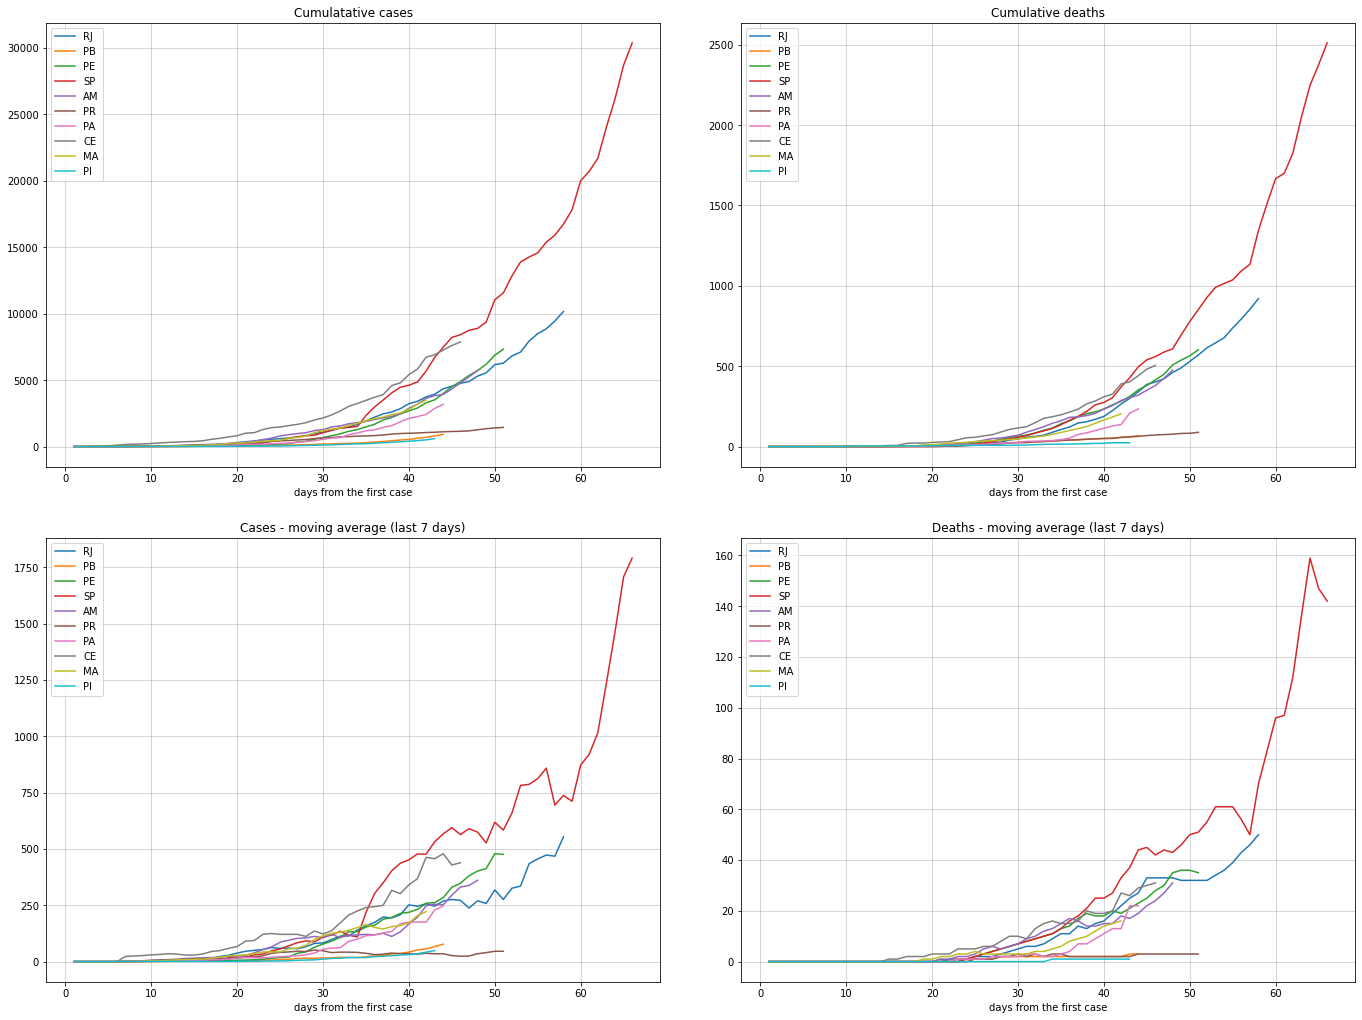

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Cumulative deaths")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cases - moving average (last 7 days)")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    ax1.plot(df[df['state'] == state].day, df[df['state'] == state].cases, label = state)
    ax2.plot(df[df['state'] == state].day, df[df['state'] == state].deaths, label = state)
    ax3.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_cases, label = state)
    ax4.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_deaths, label = state)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/brazilian_states_cases_deaths.png')

### Generating the HTML file

In [69]:
f = open('../html/brazil_analysis.html', 'w')
f1 = open('../html/templates/brazil_analysis_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_03.html', 'r').read()

readme = f1
readme += '<p>Estas análises são relativas aos dados da pandemia Covid19 no Brasil até a data de <strong>' + today + '</strong>.</p>'
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais mortais do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da média móvel de 7 dias do percentual de mortalidade de cada estado.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais transmissíveis do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da média móvel de 7 dias do percentual de casos acumulados de cada estado.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

###########################################

f = open('../html/brazil_analysis_EN.html', 'w')
f1 = open('../html/templates/brazil_analysis_EN_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_EN_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_EN_03.html', 'r').read()

readme = f1
readme += '<p>These analysis are related to Brazil Convid19 pandemic data up to <strong>' + today + '</strong>.</p>'
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' deadliest states of Brazil</h3>'
readme += '          <p>This ranking is done from the moving avarege of the last 7 days over the mortality percentage of each state.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' most transmissible states of Brazil</h3>'
readme += '          <p>This ranking is done from the moving avarege of the last 7 days over the cumulative cases of each state.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

print('Brazilian analysis done!')

Brazilian analysis done!


In [47]:
# df[df['state']=='SP'][['date','death_day']]